<a href="https://colab.research.google.com/github/pycroscopy/AICrystallographer/blob/master/Tutorials/DefectLocalization_ClassActivationMaps_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional neural networks for classification and localization of atomic defects

**Notebook prepared by Maxim Ziatdinov**

Contact e-mail: ziatdinovmax@gmail.com

In this notebook, I will show a simple example of how a convolutional neural netwoork can be used to identify type and location of defects in atomically-resolved data from scanning transmission electrone microscope (STEM). I will be using simulated STEM data produced by a Multislice algorithm, which is a well-known method for the simulation of the interaction of an electron beam with matter.

## Colab specs

We can run our notebook in Google Colab either on CPU or GPU. To switch between CPU and GPU go to *Runtime --> Change runtime type*.
If you have selected GPU, it will show as '/device:GPU:0' after running a cell below:

In [0]:
from tensorflow.test import gpu_device_name
gpu_device_name()

'/device:GPU:0'

We can also view CPU/GPU specs by running a cell below:

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9119050071684611497, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10191737408146269844
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 858452790690618541
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12624637191277678054
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

## Import/install modules

Let's first make sure we have the latest version of Keras:

In [0]:
%%capture
!pip install --upgrade keras

Now let's import all the necessary modules:

In [0]:
import numpy as np
import h5py
from collections import OrderedDict

import cv2
from skimage.feature import blob_log

from keras import utils
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


## Helper functions

Define some helper functions for loading training data:

In [0]:
def resize_images(image_data, target_size):
    '''Resizes training images based on the the target size defined by user'''
    img_new = np.zeros((image_data.shape[0], target_size[0], target_size[1]))
    for idx, img in enumerate(image_data):
        img = cv2.resize(img, target_size, cv2.INTER_AREA)
        img_new[idx,:,:] = img
    return img_new


def load_training_data(filepath, target_size=(64,64)):
    '''Loads training data and corresponding labels'''
    defects_d = {}
    train_imgs = np.empty((0, target_size[0], target_size[1]))
    train_lbls = np.empty((0, 1))
    with h5py.File(filepath, 'r') as f:
        for im in f:
            defects_d[f[im+'/label_data'][0]] = im
            images = f[im+'/image_data'][:]
            if images.shape[1:3] != target_size:
                images = resize_images(images, target_size)
            train_imgs = np.append(train_imgs, images, axis = 0)
            labels = f[im+'/label_data'][:].reshape(-1,1)
            train_lbls = np.append(train_lbls, labels)
    print("Training data loaded.", "\nno. of images in the training set:",
          str(train_imgs.shape[0]), "\nresolution of each image:",
          str((train_imgs.shape[1], train_imgs.shape[2])))
    return train_imgs, train_lbls, defects_d
       

def tf_format(image_data, norm = 1):
    '''Transform input data to tf/keras format'''
    image_data = np.expand_dims(image_data, axis = 3)
    image_data = image_data.astype('float32')
    if norm != 0:
        image_data = (image_data - np.amin(image_data))/np.ptp(image_data)
    return image_data

## Load and preprocess training data

We need to load the training data. The training data that we are going to use was prepared using Multislice algorithm for simulating STEM images of atomic defects in 2-dimensional WS$_{2}$. The simulations were performed using Multisclice algorithm. The simulated images were further augmented using image rotation, cropping, shear transformation and adding noise and blurring to the data. You can download the hdf5 file with training data into the VM by running the next cell:

In [0]:
!gdown https://drive.google.com/uc?id=1a-hu7IOVa-Mt3uvQrvYgNuQtXj76oEvi

Downloading...
From: https://drive.google.com/uc?id=1a-hu7IOVa-Mt3uvQrvYgNuQtXj76oEvi
To: /content/WS2-defects-s.hdf5
1.25GB [00:11, 106MB/s]


Now load the training data into the notebook:

In [0]:
filepath = 'WS2-defects-s.hdf5'
target_size = (64, 64)
X, y, labels_d = load_training_data(filepath, target_size = target_size)

Training data loaded. 
no. of images in the training set: 38070 
resolution of each image: (64, 64)


Let's plot the training images of defects for each class.

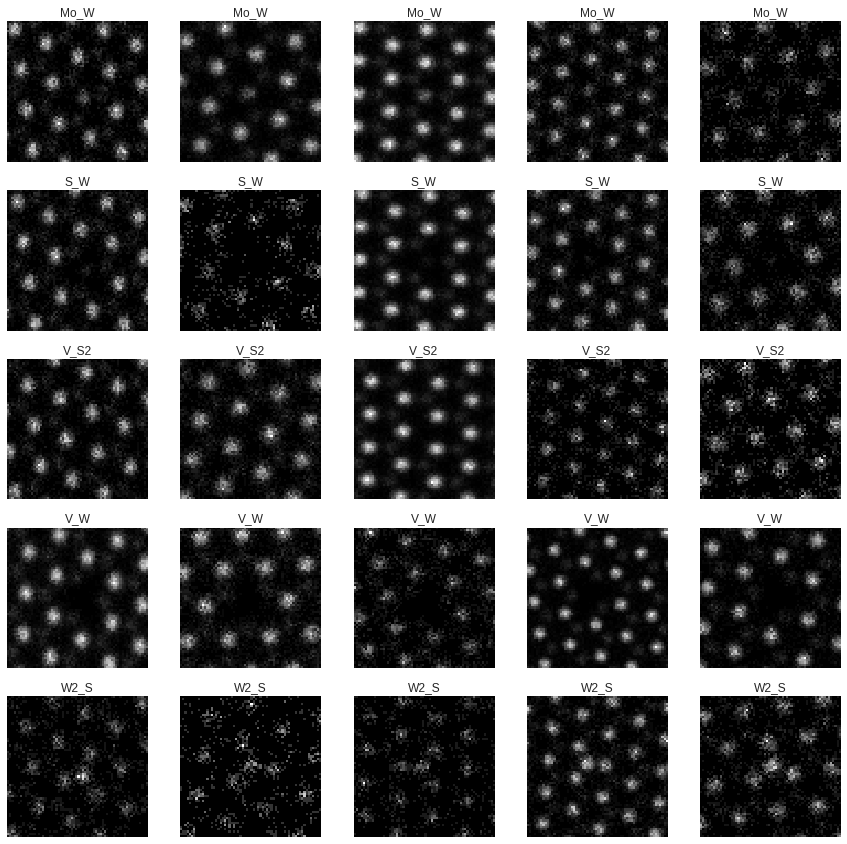

In [0]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,15))
ax_list = [item for sublist in axes for item in sublist] 
for k, v in labels_d.items():  
    for i in range(1,6):
        ax = ax_list.pop(0)
        ax.imshow(X[np.where(y==k)][i], cmap = 'gray')
        ax.set_title(v)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

We need to convert the images and labels data to the format compatible with keras/tensorflow.

In [0]:
X = tf_format(X, target_size)
y = utils.to_categorical(y, len(labels_d.keys()))

We can now split data into training and test sets:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, shuffle = True, random_state = 42)

## Create and train a CNN model

Now let's construct a simple convolutional neural network (CNN). It will have 3 convolutional layers followed by 2 dense (or fully-connected) layers and the final "softmax" layer (technically, it is also a dense layer). Alternatively, the global average pooling (GAP) layer can be used instead of the dense layers. GAP layer reduces each $h\times w$ feature map to a single number by simply taking the average of all $hw$ values. The CNN woth GAP layer(s) can be used for "free" localization of objects for models with only image-level labels. To avoid overfitting, we will be using dropout layers.

In [0]:
def cnn_model(target_size, categories = 5, GAP = True):

    visible = Input(shape=(target_size[0], target_size[1], 1), name = 'Inputs')
    x = Convolution2D(64, (3, 3), activation = 'relu', name = 'Conv-1', padding = 'same')(visible)
    x = Dropout(0.1, name = 'Dropout-1')(x)
    x = MaxPooling2D(pool_size = (2,2), name = 'Max-pooling1', padding = 'same')(x)
    x = Convolution2D(128, (3, 3), name = 'Conv-2', padding = 'same', activation = 'relu')(x)
    x = Dropout(0.2, name = 'Dropout-2')(x)
    x = MaxPooling2D(pool_size = (2,2), name = 'Max-pooling2', padding = 'same')(x)
    x = Convolution2D(256, (3, 3), name = 'Conv-3', activation = 'relu', padding = 'same')(x)
    x = Dropout(0.3, name = 'Dropout-3')(x)
    if GAP == True:
        x = GlobalAveragePooling2D(name = 'Global-Average-Pooling')(x)
    else:
        x = Flatten()(x)
        x = Dense(1024, name = 'Dense1', activation = 'relu')(x)
        x = Dense(512, name = 'Dense2', activation = 'relu')(x)
    output = Dense(categories, activation = 'softmax', name = 'Softmax-output')(x)
    model = Model(visible, output)
    
    return model

We will train a model that uses GAP layer before the final "softmax" layer

In [0]:
model = cnn_model(target_size, categories = len(labels_d.keys()), GAP = True)

We can view a model summary with the information on the number of parameters for each layer, etc.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Inputs (InputLayer)          (None, 64, 64, 1)         0         
_________________________________________________________________
Conv-1 (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
Dropout-1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
Max-pooling1 (MaxPooling2D)  (None, 32, 32, 64)        0         
_________________________________________________________________
Conv-2 (Conv2D)              (None, 32, 32, 128)       73856     
_________________________________________________________________
Dropout-2 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
Max-pooling2 (MaxPooling2D)  (None, 16, 16, 128)       0         
__________

Finally, we compile and train a model

In [0]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath="/tmp/weights_WS2_test.hdf5", verbose=0, save_best_only=True)
callback_tb = TensorBoard(log_dir='/tmp/Multislice3_def1-6', histogram_freq=0,  write_graph=True, write_images=False)
early = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')

history = model.fit(X_train, y_train, epochs=75, batch_size = 32, shuffle=True, verbose = 1,
          validation_data = (X_test, y_test), callbacks = [checkpointer, callback_tb, early])

Train on 28552 samples, validate on 9518 samples
Epoch 1/75
28552/28552 [==============================] - 36s 1ms/step - loss: 1.6089 - acc: 0.2055 - val_loss: 1.6048 - val_acc: 0.2527
Epoch 2/75
28552/28552 [==============================] - 34s 1ms/step - loss: 1.4604 - acc: 0.3225 - val_loss: 1.2565 - val_acc: 0.3999
Epoch 3/75
28552/28552 [==============================] - 34s 1ms/step - loss: 0.7968 - acc: 0.6033 - val_loss: 0.6450 - val_acc: 0.6881
Epoch 4/75
28552/28552 [==============================] - 34s 1ms/step - loss: 0.5437 - acc: 0.7396 - val_loss: 0.7665 - val_acc: 0.6085
Epoch 5/75
28552/28552 [==============================] - 34s 1ms/step - loss: 0.4354 - acc: 0.8014 - val_loss: 0.4818 - val_acc: 0.8322
Epoch 6/75
28552/28552 [==============================] - 34s 1ms/step - loss: 0.3660 - acc: 0.8361 - val_loss: 0.3691 - val_acc: 0.8289
Epoch 7/75
28552/28552 [==============================] - 34s 1ms/step - loss: 0.3228 - acc: 0.8602 - val_loss: 0.3303 - val_acc:

Save model and weights

In [0]:
model.save('WS2-test.h5')
print('Saved model and weights to disk')

Saved model and weights to disk


Plot accuracy and/or loss graphs

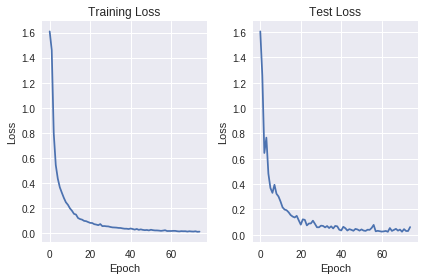

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(history.history['loss'])
#ax1.set_yscale('log')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax2.plot(history.history['val_loss'])
#ax2.set_yscale('log')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')
f.tight_layout()

## Class activation maps

We will now see how well our trained model makes predictions. For simipicity, we will be just using images from a test set.

We are going to use a technique called class activation maps (CAM). This technique was originally developed for natural image processes (see cnnlocalization.csail.mit.edu). Here we will adapt it for atomically resolved imaging of defects.

The idea of CAM is very simple: we extract weights from the final ("softmax") layer of the network and calculate the dot product with  features (activation maps) in the final *convolutional* layer (the one before GAP layer). Let's write simple functions that will get both activation maps and necessary weights from a trained model:

In [0]:
def get_activation_maps(model, inputs, layer_num, learning_phase=0):
    get_layer_output = K.function([model.layers[0].input, K.learning_phase()], [model.get_layer(last_conv_layer).output])
    layer_out = get_layer_output([inputs, learning_phase])[0]
    layer_out = layer_out[0, :, :, :]
    layer_out = np.transpose(layer_out,(2, 0, 1))
    return layer_out

def get_SoftmaxWeights(model):
    return model.layers[-1].get_weights()[0]

We need to specify the name of the last conv layer (can be found using model.summary() )

In [0]:
last_conv_layer = "Conv-3"

Now we are going to extract defect type and CAMs for each image of interest and store this information in a dictionary.

In [0]:
CAM_defects = {}
for i1, img in enumerate(X_test[0:100]):
    img = np.expand_dims(img, axis = 0)
    predictions = model.predict(img)
    target_class = predictions.argmax() # manual input IF more than 1 class in the image
    softmax_weights = get_SoftmaxWeights(model)
    conv_out = get_activation_maps(model, img, last_conv_layer)
    cam = np.zeros(shape = conv_out.shape[1:3], dtype = np.float32)
    for idx, weight in enumerate(softmax_weights[:, target_class]):
        cam += weight * conv_out[idx, :, :]
    cam = cv2.resize(cam, target_size)
    cam = (cam - np.amin(cam))/np.ptp(cam)
    max_coord = blob_log(cam, min_sigma=0.5)
    dictionary = OrderedDict()    
    dictionary['Image'] = img[0,:,:,0]
    dictionary['Defect type'] = labels_d[target_class]
    dictionary['Defect coordinates'] = max_coord[:,0:2]
    dictionary['CAM'] = cam
    CAM_defects[i1] = dictionary

In [0]:
np.save("WS2-CAM_defects.npy", CAM_defects)

We can now visualize class activation maps for different defect types. Notice that we can use a standard blob detector technique to find a location of defects from class activation maps data. Thus, even though we trained our model on image-level labels, we can identify location of defect(s) in each image in pixel-wise fashion.

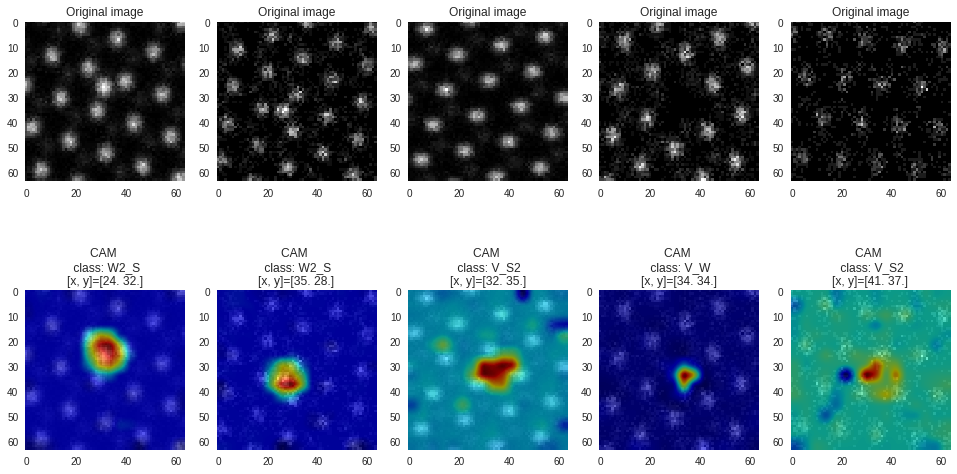

In [0]:
plt.figure(figsize=(20, 14))

n = 6
for i in range(1, n):
    original_image, defect_type, defect_coordinates, cam = CAM_defects[i].values()
    ax = plt.subplot(3, n, i)
    ax.imshow(original_image, cmap = 'gray')
    ax.set_title('Original image') 
    ax.grid('off')
    ax = plt.subplot(3, n, i + n)
    ax.imshow(cam, cmap = 'jet', Interpolation = 'Gaussian')
    ax.grid('off')
    ax.imshow(original_image, cmap = 'gray', alpha = 0.4)
    ax.set_title('CAM \n class: ' + defect_type + '\n[x, y]='+str(defect_coordinates[0]))
    ax.grid('off')